## Line Following with Obstacle Avoidance

The final task of this week is a combination of the line following, obstacle detection, and wall following behaviors.

The robot should follow the line until an obstacle is detected in its path. Then, the robot will turn right and follow the wall at its right until the line is detected again, and it will resume the line following behavior.

Please watch the following demo video:

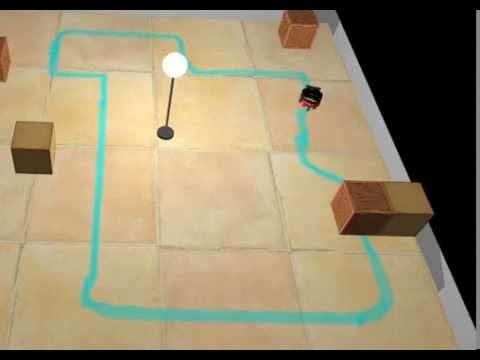

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo('Jd1jpt3pgc8')

This is the most complex task that we have programmed so far, thus it is a nice candidate for developing with the so-called [**top-down** approach](https://en.wikipedia.org/wiki/Top-down_and_bottom-up_design). With this methodology, we start with a high-level algorithm, and break it down into its components:

    repeat forever
        follow line until an obstacle is detected
        get close to the wall
        follow wall until a line is detected
        get close to the line

### Initialization
First, we need to import all the required modules.

In [203]:
import packages.initialization
import pioneer3dx as p3dx
p3dx.init()
import cv2
import numpy
import math

In [204]:
MIN_WALL_THRESHOLD = 0.3
MAX_WALL_THRESHOLD = 0.4
    
DEF_X_SPEED = 0.2       # default forward velocity
DEF_YAW_SPEED = 0.15    # default turning velocity

### Component functions
The first function must return `True` if an obstacle is detected in front of the robot, or `False` otherwise.

In [205]:
def is_obstacle_detected():
    if min(p3dx.distance[3:5]) > MIN_WALL_THRESHOLD:
        return False
    else:
        return True

The second function is the line following behavior as seen in previous notebooks during this week.

In [206]:
def follow_line():
    print('Following the line')
    width = p3dx.image.shape[1]
    Kp = 0.1
    while not is_obstacle_detected():
        cx, cy = line_centroid(p3dx.image)
        err = cx - (width/2)
        linear = 2 #The linear velocity is constant, e.g. 2m/s
        angular = - Kp * err # the angular velocity w
        move(linear, angular)
    print('Obstacle detected')

The next function was developed in the previous week: the robot turns until it is approximately parallel to the wall.

In [207]:
def getWall():
    rightSide = p3dx.distance[7]
    # turn until the wall is detected by sonar 0
    while rightSide > MAX_WALL_THRESHOLD:
        yawSpeed = DEF_YAW_SPEED * 3
        move(0,yawSpeed)
        rightSide = p3dx.distance[7]
        
    print('Prepare to follow the wall')
    move(0,0)

The next function is checked during the wall following behavior: it must return `True` when the line is again detected, or `False` otherwise.

In [208]:
def is_line_detected():
    cx, cy = line_centroid(p3dx.image)
    if cx and cy is not 0:
        return True
    else:
        return False    

Next, we reuse the wall following behavior from previous week.

In [209]:
def follow_wall():
    print('Following the wall')
    while not is_line_detected():
        leftSide, frontSide, rightSide = getSonars()
        # by default, just move forward
        xSpeed = DEF_X_SPEED
        yawSpeed = DEF_YAW_SPEED
        # if we're getting too close to the wall with the front side...
        if frontSide < MAX_WALL_THRESHOLD:
            # go backward and turn right quickly (x4)
            xSpeed = -0.1
            yawSpeed = DEF_YAW_SPEED * 4 # !!! check sign
        else:
            # if we're getting too close to the wall with the left side...
            if rightSide < MIN_WALL_THRESHOLD:
                # move slowly forward (x0.5) and turn right
                xSpeed  = DEF_X_SPEED * 0.5
                yawSpeed = DEF_YAW_SPEED # !!! check sign
            else:
                # if we're getting too far away from the wall with the left side...
                if rightSide > MIN_WALL_THRESHOLD:
                    # move slowly forward (x0.5) and turn left
                    xSpeed  = DEF_X_SPEED * 0.5
                    yawSpeed = -DEF_YAW_SPEED # !!! check sign
        # Move the robot
        move(xSpeed,yawSpeed)
    move(0,0)
    print('Line detected')

Finally, a function is needed for turning the robot slightly until it is approximately parallel to the line again.

In [210]:
def getLine():
    width = p3dx.image.shape[1]
    Kp = 0.1
    err = 100
    while err > 10:
        cx, cy = line_centroid(p3dx.image)
        err = cx - (width/2)
        linear = 2 #The linear velocity is constant, e.g. 2m/s
        angular = - Kp * err # the angular velocity w
        move(linear, angular)
    move(0,0)

Some additional lower-level functions are required (guess which ones?).

You can define them in the next empty cell.

In [211]:
# Lower-level functions
def line_centroid(image):
    hsv = cv2.cvtColor(p3dx.image, cv2.COLOR_RGB2HSV)
    lower_cyan = numpy.array([80, 100, 100])
    upper_cyan = numpy.array([100, 255, 255])
    mask = cv2.inRange(hsv, lower_cyan, upper_cyan)
    mask[0:80, 0:150] = 0
    M = cv2.moments(mask)
    if int(M['m00']) is not 0:
        cx = int(M['m10']/M['m00'])
        cy = int(M['m01']/M['m00'])
        return cx, cy
    else:
        cx = 0
        cy = 0
        return cx, cy

In [212]:
def move(V_robot,w_robot):
    r = 0.1953 / 2
    L = 0.33
    w_r = (2 * V_robot + L * w_robot) / (2*r)
    w_l = (2 * V_robot - L * w_robot) / (2*r)
    p3dx.move(w_l, w_r)

In [213]:
def getSonars():
    leftSide = min(p3dx.distance[0:3])
    frontSide = min(p3dx.distance[3:5])
    rightSide = min(p3dx.distance[5:])
    return leftSide, frontSide, rightSide

### Main loop
The main loop looks very similar to the proposed algorithm:

In [214]:
p3dx.tilt(-0.47)
try:
    while True:
        follow_line()
        getWall()
        follow_wall()
        getLine()
except KeyboardInterrupt:
    move(0,0)

Following the line
Obstacle detected
Prepare to follow the wall
Following the wall
Line detected
Following the line
Obstacle detected
Prepare to follow the wall
Following the wall
Line detected
Following the line
Obstacle detected
Prepare to follow the wall
Following the wall
Line detected
Following the line
Obstacle detected
Prepare to follow the wall
Following the wall
Line detected
Following the line
Obstacle detected
Prepare to follow the wall
Following the wall
Line detected
Following the line


Exception: The robot needs initialization - has the simulation been restarted?

Did it work? Congratulations, you have completed the task of this week!

---
#### Try-a-Bot: an open source guide for robot programming
Developed by:
[![Robotic Intelligence Lab @ UJI](img/logo/robinlab.png "Robotic Intelligence Lab @ UJI")](http://robinlab.uji.es)

Sponsored by:
<table>
<tr>
<td style="border:1px solid #ffffff ;">
<a href="http://www.ieee-ras.org"><img src="img/logo/ras.png"></a>
</td>
<td style="border:1px solid #ffffff ;">
<a href="http://www.cyberbotics.com"><img src="img/logo/cyberbotics.png"></a>
</td>
<td style="border:1px solid #ffffff ;">
<a href="http://www.theconstructsim.com"><img src="img/logo/theconstruct.png"></a>
</td>
</tr>
</table>

Follow us:
<table>
<tr>
<td style="border:1px solid #ffffff ;">
<a href="https://www.facebook.com/RobotProgrammingNetwork"><img src="img/logo/facebook.png"></a>
</td>
<td style="border:1px solid #ffffff ;">
<a href="https://www.youtube.com/user/robotprogrammingnet"><img src="img/logo/youtube.png"></a>
</td>
</tr>
</table>